# RSCAM Assessment 3


# Simulating Langevin dynamics

We assume we have some complicated potential energy function $U(q)$, and the target distribution $\rho_\beta(q)$ where 
$$\rho_\beta(q) = \frac1{Z_\beta} \exp(-\beta U(q)),\qquad Z_\beta=\int_{-\infty}^\infty \exp(-\beta U(q) )\,\rm{d}q.$$
Ultimately we want to compute averages with respect to this distribution, which we can write as an integral against $\rho_\beta(q)$.

If we augment our distribution to include momentum $p$, then we can write 
$$\rho_\beta(q,p) = \frac1{\hat{Z}_\beta} \exp(-\beta H(q,p) ),\qquad \hat{Z}_\beta=\int_{-\infty}^\infty \exp(-\beta H(q,p) )\,\rm{d}q\rm{d}p,$$
where $H$ is the familiar Hamiltonian, or total energy function, that we've seen before
$$H(q,p) = \frac12 \|p\|^2 + U(q)$$
where we have assumed mass is 1 for all degrees of freedom.   (It is easy to change this if we wanted to include a nonunit mass, but just complicates the notation a bit.)

As $q$ and $p$ are independent, we can integrate out over the momentum variables and recover the correct sampling in $q$.  This means that we can think of the momenta as intermediate or 'auxiliary' variables if our main goal is to compute averages of q-dependent functions.

The momentum variables are useful as they can allow a system to continue going in an unfavourable direction (i.e. up barriers) via inertia. This property is lacking in, for example, Brownian dynamics.

The equations of motion for Langevin dynamics are
$${ \begin{array}{rcl}
\dot{q} &=& p\\
\dot{p} &=& -\nabla U(q) - \gamma p + \sqrt{2\gamma /\beta} \dot{W}\end{array}}$$
where $W$ is a Wiener process, and $\gamma>0$ is the _friction constant_, a parameter that describes how rapidly energy is dissipated from the system to its surroundings as well as the rate at which the momentum is randomized ($\gamma$ should be viewed as a rate). Note that if $\gamma=0$ then the system reduces to the constant energy (Hamiltonian) dynamics that we looked at earlier in the term when we studied symplectic methods. If $\gamma$ is large, or infinite, then solutions will tend towards solutions to Brownian dynamics, as mentioned in lecture.   In between, $\gamma$ alters the way we converge to equilibrium (or the rate at which averages of functions taken along stochastic paths converge to their long term (ensemble) averages.

We can rewrite Langevin dynamics as the sum of three terms:


$$\left[ \begin{array}{c} \dot{q}\\ \dot{p} \end{array}\right]
= \underbrace{\left[\begin{array}{c} p \\0 \end{array}\right]}_\text{A}
+ \underbrace{\left[\begin{array}{c} 0\\F(q) \end{array}\right]}_\text{B}
+ \underbrace{\left[\begin{array}{c} 0\\-\gamma p + \sqrt{2\gamma/\beta} \dot{W} \end{array}\right]}_\text{O}.$$
As usual $F(q)=-\nabla U(q)$ denotes the force.

As discussed in lecture, we can solve each of the pieces _exactly_ in the weak (distributional) sense:

$$\text{(A) dynamics step}$$
$$ \left| \begin{array}{rcl} 
q(t+h)&\leftarrow&q(t) + h  p(t) \\
\qquad p(t+h)&\leftarrow&p(t)
\end{array}\right.$$

$$\text{(B) dynamics step}$$
$$ \left| \begin{array}{rcl} 
q(t+h)&\leftarrow&q(t) \\
\qquad p(t+h)&\leftarrow&p(t) + h F(q(t))
\end{array}\right.$$

$$\text{(O) dynamics step}$$
$$ \left| \begin{array}{rcl} 
q(t+h)&\leftarrow&q(t) \\
R(t+h)&\leftarrow& \text{Normal}(0,I)\\
\qquad p(t+h)&\leftarrow&\exp(-\gamma h) p(t) + \sqrt{1/\beta}\sqrt{1-\exp(-2\gamma h)} R(t+h)
\end{array}\right.$$

The solution of the O step comes from the solution for the Ornstein-Uhlenbeck process, with $R(t)\in\mathbb{R}^N$ a vector of independent and identically distributed (i.i.d.) normal random numbers.

In [2]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt 
from IPython.display import HTML
plt.rc('font', size=14) # makes the fonts used in graphs a bit larger (and clearer)!

codes for the `B_step` and `O_step` functions below to match the above algorithms. 

In [3]:
def A_step( qp , h ):
    q,p = qp
    
    q = q + h*p
    
    return [q,p]

def B_step( qp , h, force ):
    q,p = qp
    
    F = force(q)
    
    p = p + h*F
    
    return [q,p]

def O_step( qp , h,gamma, beta ):
    q,p = qp
    
    alpha = np.exp(-h*gamma)
    beta = np.sqrt(1/beta) 
    delta = np.sqrt(1 - alpha**2)
    
    R = np.random.randn( q.size ).reshape( q.shape)
    p = alpha* p + beta* delta * R
    
    return [q,p]

Next we can define a method integrating Langevin Dynamics by performing these steps in sequence. For example, the _ABO_ method looks like this:

In [4]:
def ld_ABO(q,p,h,gamma,beta,force):
    
    # The algorithm "ABO" does A then B then O 
    
    qp = np.copy([q,p])  #this just translates the separate q and p vectors 
                #into a single vector composed from the pair.
    
    qp = A_step(qp , h )
    qp = B_step(qp, h, force)
    qp = O_step(qp, h, gamma, beta )
    q,p = qp
    
    return q , p 

We can feed this function into the `run_simulation` function  (see below) as the 'step_function' argument. Note that beta, the reciprocal temperature parameter, must be fed through the functions together with gamma.

In [5]:
def run_simulation( q0,p0, Nsteps, h, gamma, beta, step_function, force_function):
    
    q_traj = [np.copy(q0)] 
    p_traj = [np.copy(p0)]
    t_traj = [0]

    q = np.copy(q0) 
    p = np.copy(p0)
    t = 0 

    for n in range(Nsteps):
        q,p = step_function(q, p, h, gamma, beta, force_function)
        t = t + h 

        q_traj += [q] 
        p_traj += [p]   
        t_traj += [t] 

    q_traj = np.array(q_traj) 
    p_traj = np.array(p_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, p_traj, t_traj

In discussing the evolving distribution associated to the numerical method, one normally thinks of taking a large number of separate sampling paths and using the snapshots of them at a given time as a discrete approximation to the evolving probability distribution.

On the other hand, if one is interested in the long term averages, it is not necessary to use this approach.   Rather than taking many walkers and looking at the evolving distributions, one may run a single, long simulation. It can be shown that taking averages over this long simulation is equivalent to looking at the large time limit of lots of walkers, i.e. time averages along a trajectory will still equal averages with respect to the target distribution.

For example, for a Gaussian we can look at the sampled distributions generated by a single path as follows:

In [6]:
def force_Gaussian(q):
    # U(q) = q^2 /2
    F = -q 
    return F

# Initialize one walker from a Gaussian distribution

q0 = np.random.randn(1)
p0 = np.random.randn(1)

Nsteps = 10000
h = 0.5
gamma = 1.0
beta = 1.0

# Run one long trajectory of Nsteps, using the ABO scheme
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_ABO, force_Gaussian)

And then plot the resulting trajectories of the $q$ variable and the distributions marginalised in $q$ and $p$:

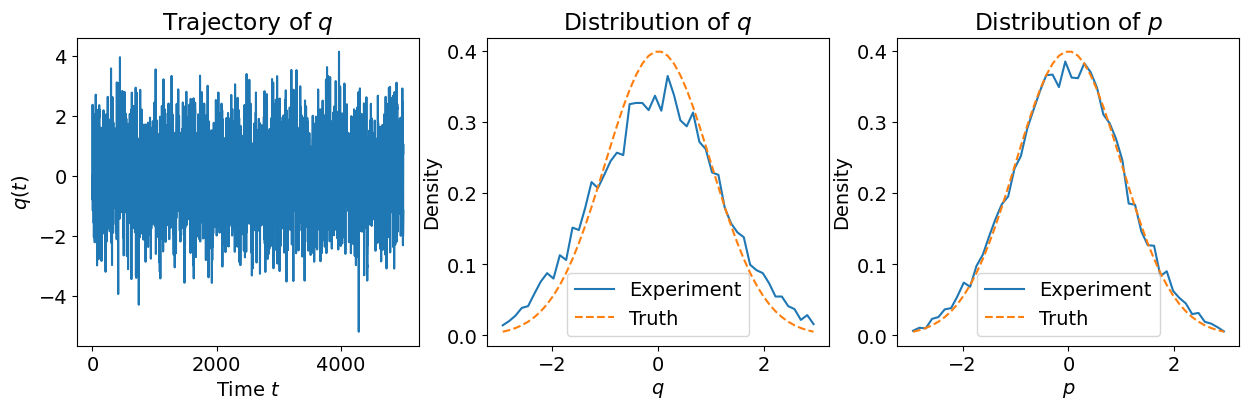

In [7]:
fig = plt.figure(figsize=[15,4])

plt.subplot(1,3,1)
plt.plot( t_traj, q_traj )
plt.title('Trajectory of $q$')
plt.ylabel('$q(t)$')
plt.xlabel('Time $t$')

plt.subplot(1,3,2) 
histogram,bins = np.histogram(q_traj,bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- beta*(midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('Distribution of $q$')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()

plt.subplot(1,3,3) 
histogram,bins = np.histogram(p_traj,bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- beta*(midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('Distribution of $p$')
plt.xlabel('$p$')
plt.ylabel('Density')
plt.legend()
plt.show()

Discuss the gap between the distribution of points generated by the numerical method and the exact, true Gaussian distribution.   


Here $q$ denotes the the trajectories of the particle, with the blue solid line in the middle figure being the sampled trajectories which we compaire with the orange dashed lined that represent the gaussain distribution which we expect to have for our $q$ trajector. However, from the figure we see there is a difference between them which indicates that the simultion should be ran for longer for a suitable step size. 

While $p$ denotes the momentum with again the blue curve being the results of our sampling particle while the dashed orange curve is the desired 'True" shape. The differences in this case is smaller adn we expect that the difference is reduce the longer the simulation is run for. 



Examine the above distributions obtained using histograms of the trajectories.  What happens to their accuracy (i.e. the difference between the histogram envelope and the dashed curve) if you (a) decrease or increase the stepsize, (b) decrease or increase the number of timesteps?  You may need quite significant increases in the number of steps to see a difference. 


In [8]:
## Define plotting function 
def plot_ex2(q_traj, p_traj, t_traj, h, Nsteps):
    fig = plt.figure(figsize=[15, 4])
    
    plt.subplot(1, 3, 1)
    plt.plot(t_traj, q_traj)
    plt.title('Trajectory of $q$')
    plt.ylabel('$q(t)$')
    plt.xlabel('Time $t$')
    
    plt.subplot(1, 3, 2) 
    histogram, bins = np.histogram(q_traj, bins=50, range=[-3, 3], density=True)
    midx = (bins[0:-1] + bins[1:]) / 2
    rho = np.exp(-beta * (midx**2) / 2)
    rho = rho / (np.sum(rho) * (midx[1] - midx[0]))  # Normalize rho by dividing by its approx. integral
    plt.plot(midx, histogram, label='Experiment')
    plt.plot(midx, rho, '--', label='Truth')
    plt.title('Distribution of $q$')
    plt.xlabel('$q$')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle=':', linewidth=0.5, alpha=1)  # Add darker and more transparent gridlines
    plt.xticks(np.arange(-3, 4, 1))  # Add more x-axis ticks
    plt.yticks(np.arange(0, 0.4, 0.1))  # Add more y-axis ticks
    
    plt.subplot(1, 3, 3) 
    histogram, bins = np.histogram(p_traj, bins=50, range=[-3, 3], density=True)
    midx = (bins[0:-1] + bins[1:]) / 2
    rho = np.exp(-beta * (midx**2) / 2)
    rho = rho / (np.sum(rho) * (midx[1] - midx[0]))  # Normalize rho by dividing by its approx. integral
    plt.plot(midx, histogram, label='Experiment')
    plt.plot(midx, rho, '--', label='Truth')
    plt.title('Distribution of $p$')
    plt.xlabel('$p$')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle=':', linewidth=0.5, alpha=1)  # Add darker and more transparent gridlines
    plt.xticks(np.arange(-3, 4, 1))  # Add more x-axis ticks
    plt.yticks(np.arange(0, 0.4, 0.1))  # Add more y-axis ticks
    
    plt.subplots_adjust(wspace=0.2, hspace=0.5)  # Add more space between subplots
    plt.suptitle(f'Simulation h={h} and Number of steps = {Nsteps}', y=1.05)  # Adjust y value for more space
    plt.show()

## End plotting function 


Exploring the potential impact of adjusting the step size and the number of time steps on the accuracy of the simulation:

## Step Size:
Reducing the step size generally leads to more accurate simulations by providing a finer-grained approximation of continuous Langevin dynamics. The histograms are expected to closely match the dashed curves (representing the true distributions) because the simulation captures more details of the system's behavior.
Conversely, larger step sizes may result in less accurate simulations due to coarser discretization. The histograms may deviate more from the dashed curves, indicating that the simulation might miss fine-scale features of the true distribution.

### Analysis
Observing the effects of step size, we find that there exists an optimal step size for the system, which occurs around $h = 0.1$ for a given number of steps, say 10,000. The reason for this optimal step size is that the $q$ trajectories from the simulation better fit the 'true' Gaussian distribution. However, increasing the step size causes the tails of the sampled distribution to become heavier, suggesting a loss of fine-scale features in the true distribution. A smaller step size $h = 0.01$ would require an increase in the number of steps to converge to the true distribution fully, as evidenced by $h = 0.01$ not precisely representing the true distribution.

See code and plot below for a visual representation of these observations:

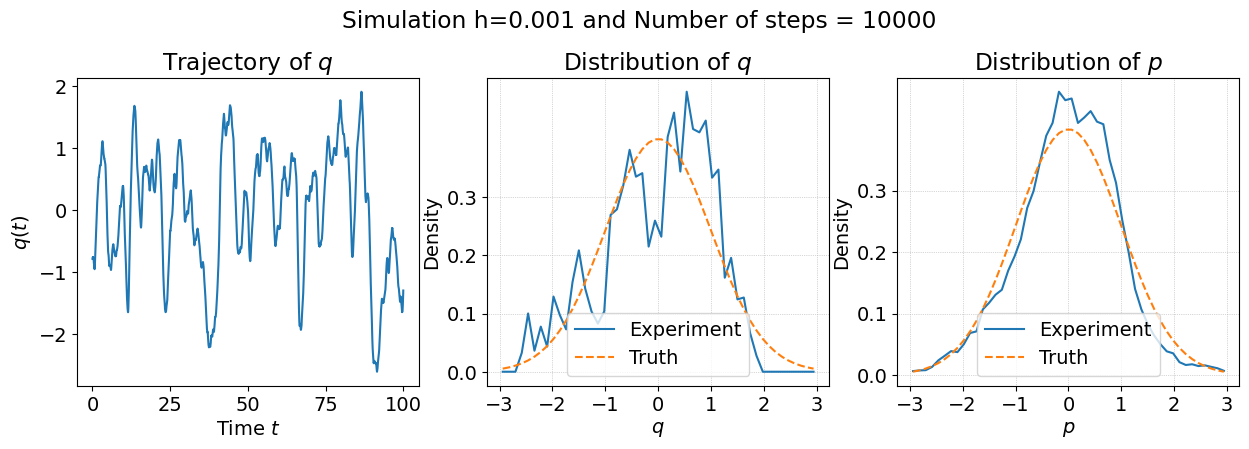

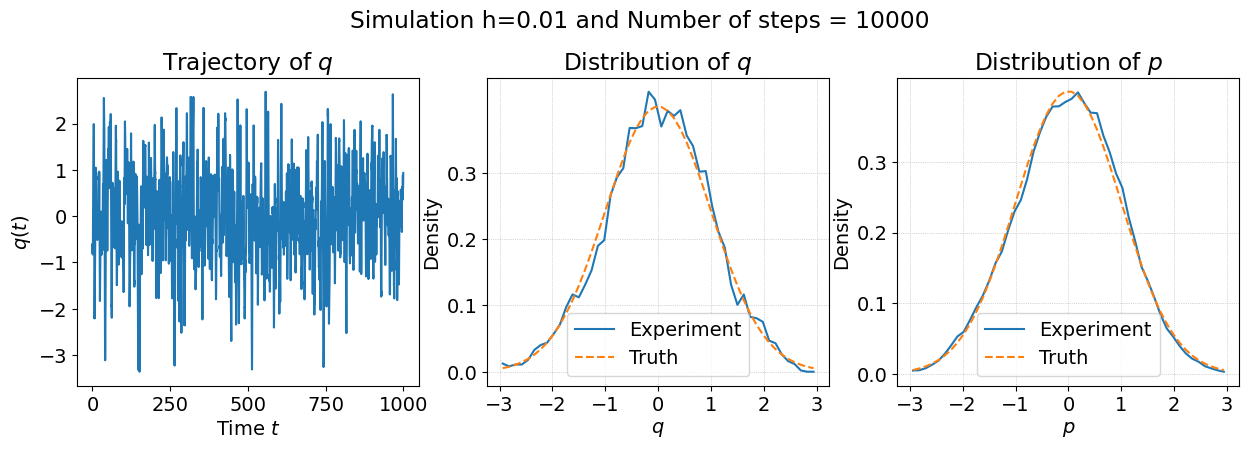

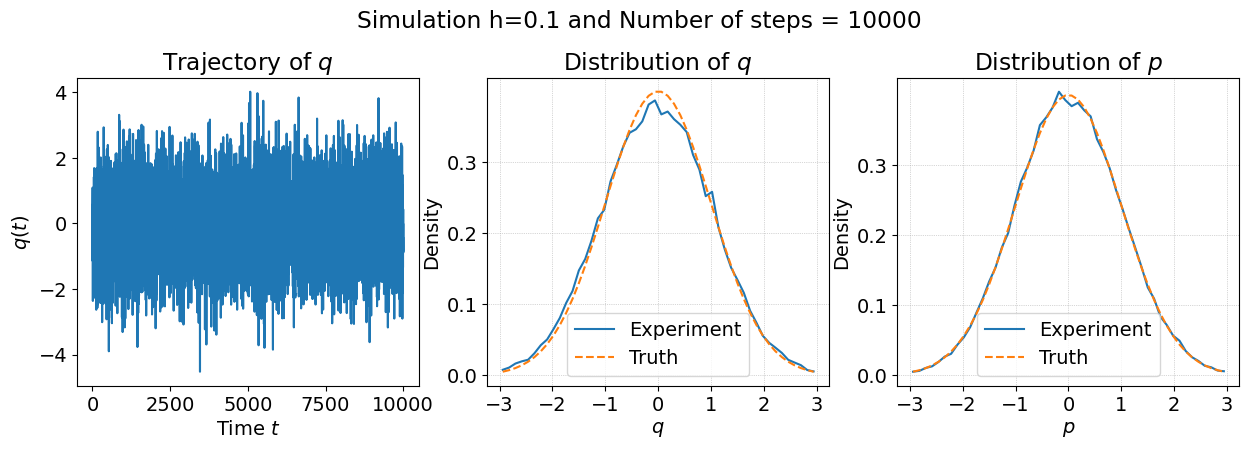

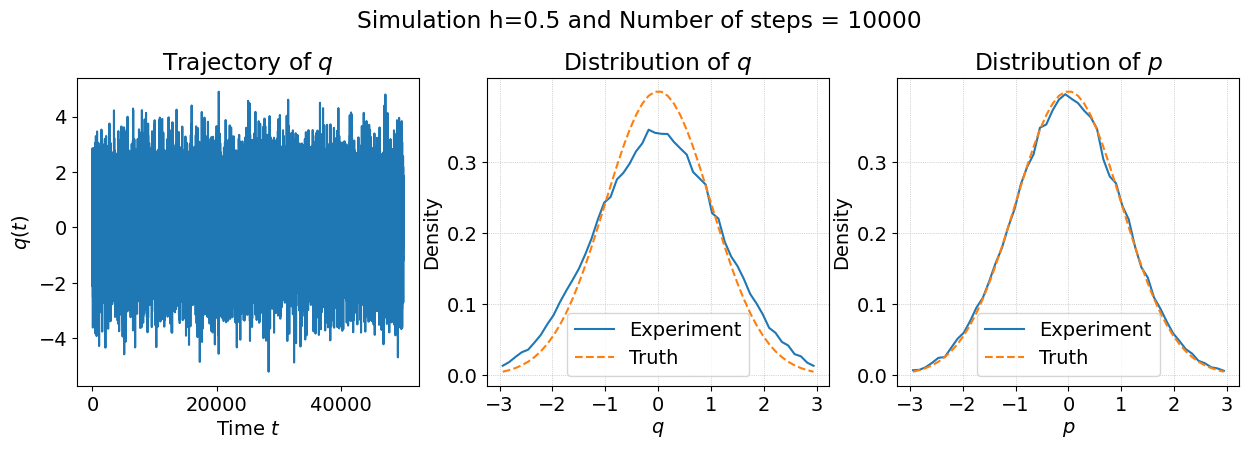

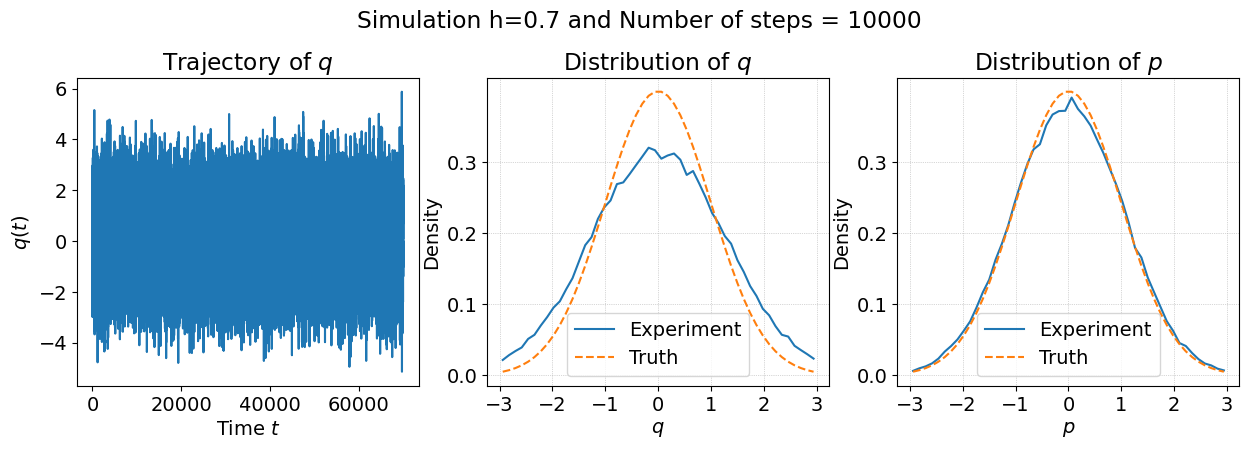

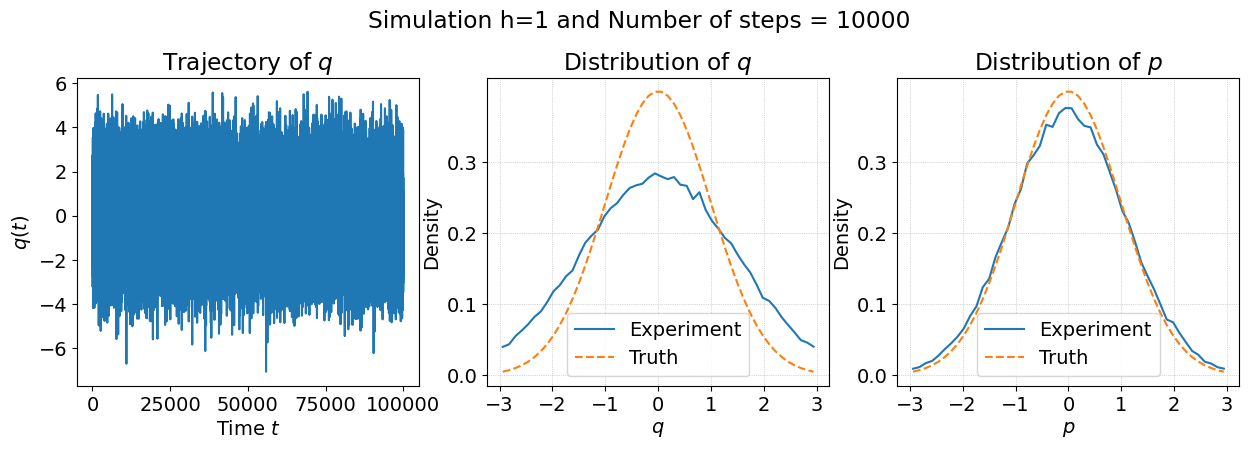

In [9]:
hs = [ 0.001, 0.01, 0.1, 0.5 , 0.7 ,1 ] 

N_steps = int(1e5)

for h in hs: 
    q_traj, p_traj, t_traj = run_simulation(q0, p0, N_steps , h, gamma, beta, ld_ABO, force_Gaussian)
    plot_ex2( q_traj, p_traj, t_traj, h , Nsteps)

## Number of Time Steps:

Decreasing the number of time steps may lead to a less accurate simulation because the dynamics are sampled less frequently. The histograms may deviate more from the true distributions, especially in capturing detailed features.

Increasing the number of time steps generally improves accuracy by providing a more detailed exploration of the phase space.The histograms are expected to be closer to the true distributions because the simulation has more opportunities to capture the system's dynamics. However, an increase in steps is computation heavy and thus the simulation will require more resources in order to run. 
Therefore, there is a trade off between comptation costs and accuary of the simualtion to consider.

### Analysis
To illustrate this trade-off, we conducted simulations with a fixed step size of $0.1$ and varied the number of steps over a wide range. The results are as follows:

For small values of $N$, the fit between the recovered distribution from the simulation and the true distribution is poor. The histograms show artifacts in the form of sharp, jagged fluctuations, indicating numerical simulation challenges.

As $N$ increases, the computational time also rises. However, this investment leads to smoother curves in the plots, reducing the artifacts and improving the overall fit to the true distribution.

It's worth noting that even at N=1e5N=1e5, a kink at the peak of the distribution for $q$ is observed, which is considered undesirable.

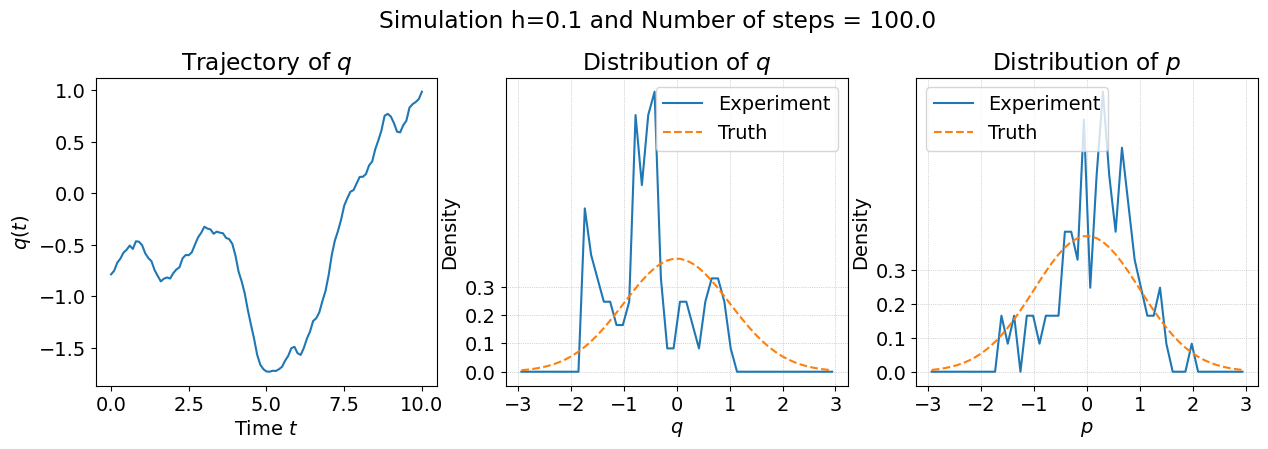

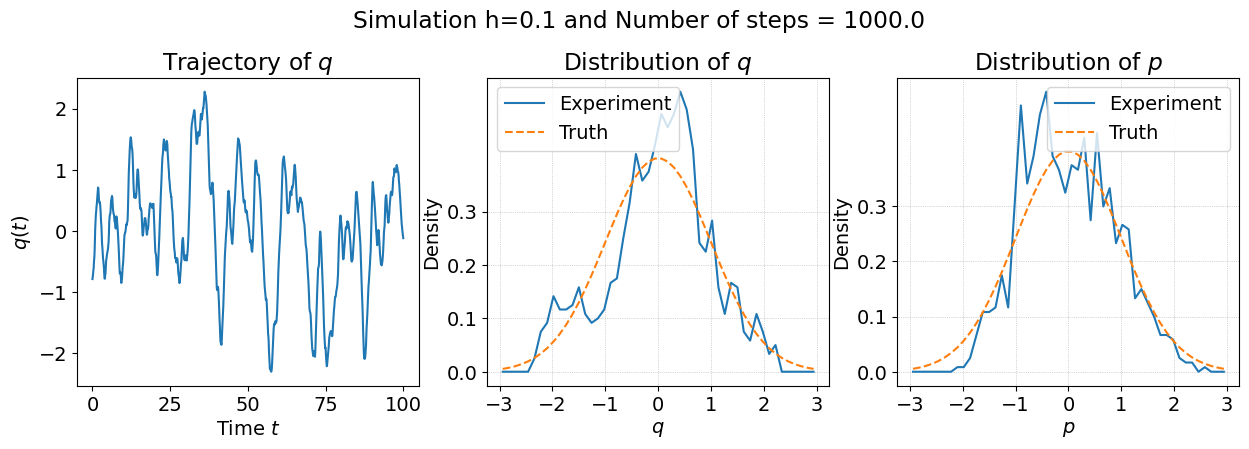

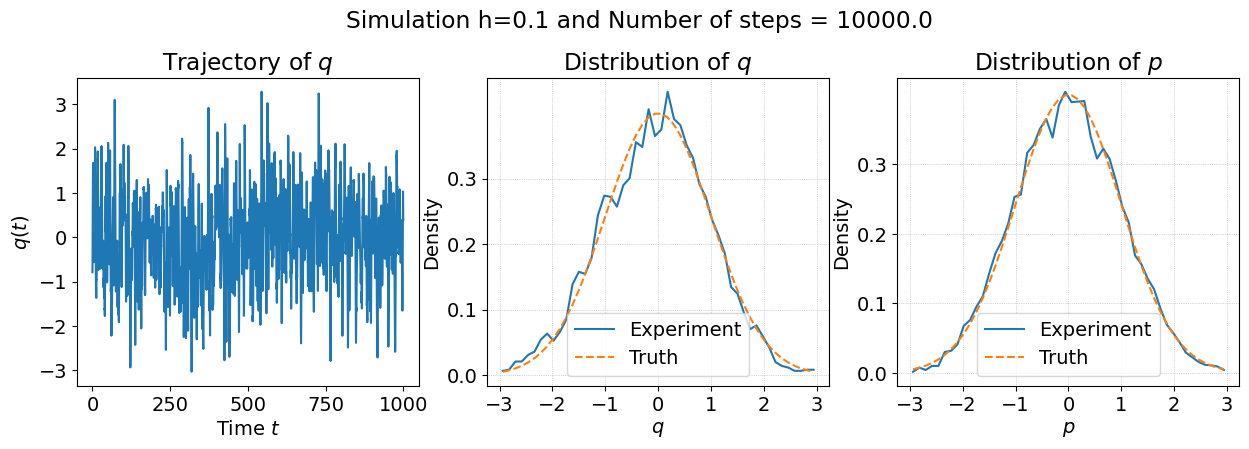

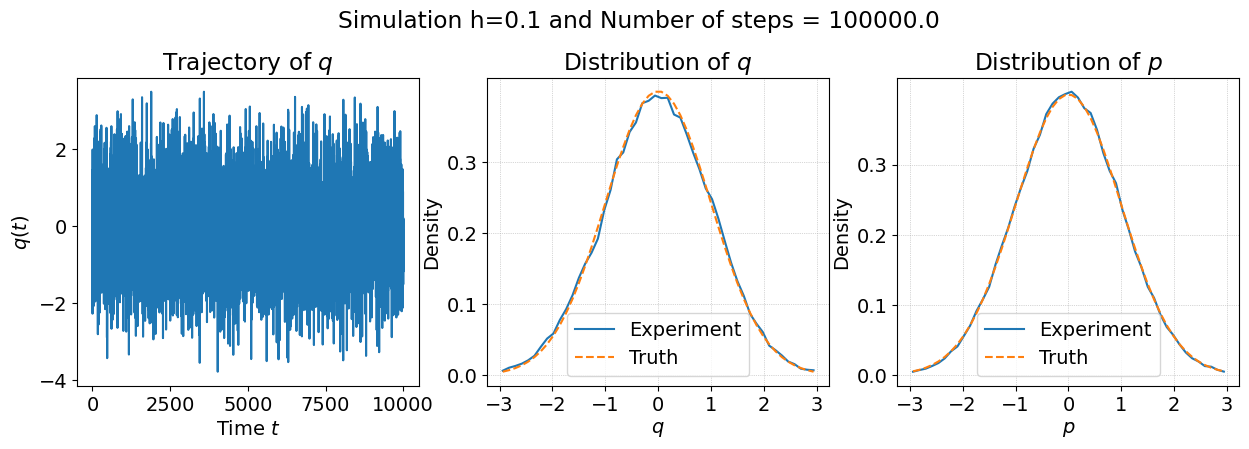

In [10]:
h = 0.1 # step size 
Nsteps_list = [ 1e2,1e3, 1e4, 1e5] 
for Nsteps in Nsteps_list: 
    q_traj, p_traj, t_traj = run_simulation(q0, p0, int(Nsteps) , h, gamma, beta, ld_ABO, force_Gaussian)
    plot_ex2( q_traj, p_traj, t_traj, h , Nsteps)

Implement the _BAOAB_ method.  

*Recall that if a character appears twice in the string describing the method then the corresponding integration is for time $h/2$, rather than $h$.*

In [11]:
def ld_BAOAB(q,p,h,gamma,beta, force):
    
    qp = np.copy([q,p])
     
    # your code goes here!
    qp = B_step(qp, h/2, force)
    qp = A_step(qp, h/2) 
    qp = O_step(qp, h, gamma, beta) 
    qp = A_step(qp, h/2) 
    qp = B_step(qp, h/2, force)
    
    q,p = qp
    
    return q , p 

Compare the exact distribution to sampled distributions computed using  _BAOAB_ by making plots of their q trajectories and q and p marginal densities (as done above for the Gaussian case). Compute distributions in both configurations ($q$) and momenta ($p$), for the potential energy function shown below. Use Nsteps = 10000, a stepsize of $h=0.1$, $\gamma=1$, and $\beta=1.0$ 
$$U(q) = q^2(.1+\sin^2(q))$$
Discuss the results obtained. 

*(Run using one path for a long enough simulation so that your histogram looks smooth. Include axis labels, legends and titles where necessary.)*

In [12]:
def my_pot(q):
    U= (q**2)*(np.sin(q)**2 +0.1)
    return U
def my_force(q):
    # U(q) = q**2*(sin(q)**2 + 0.1)
    q= np.copy(q)
    
    F = -2*q*(np.sin(q)**2 +0.1) - 2*q**2*np.sin(q)*np.cos(q)
    
    return F

In [13]:
### Define a plotting function
def plot_ex4( q_traj, p_traj, t_traj, h , Nsteps):
    fig = plt.figure(figsize=[15,4])
    
    plt.subplot(1,3,1)
    plt.plot( t_traj, q_traj )
    plt.title('Trajectory of $q$')
    plt.ylabel('$q(t)$')
    plt.xlabel('Time $t$')
    
    plt.subplot(1,3,2) 
    histogram,bins = np.histogram(q_traj,bins=50,range=[-5,5], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    rho = np.exp(- beta*my_pot(midx)) # Changed to use my_pot
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
    plt.plot(midx,histogram,label='Experiment')
    plt.plot(midx,rho,'--',label='Truth')
    plt.title('Distribution of $q$')
    plt.xlabel('$q$')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle=':', linewidth=0.5, alpha=1)  # Add darker and more transparent gridlines
    plt.xticks(np.arange(-5, 5, 1))  # Add more x-axis ticks
    plt.yticks(np.arange(0, 0.5, 0.1))  # Add more y-axis ticks
    
    plt.subplot(1,3,3) 
    histogram,bins = np.histogram(p_traj,bins=50,range=[-5,5], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    rho = np.exp(- beta*(midx**2)/2)
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
    plt.plot(midx,histogram,label='Experiment')
    plt.plot(midx,rho,'--',label='Truth')
    plt.title('Distribution of $p$')
    plt.xlabel('$p$')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle=':', linewidth=0.5, alpha=1)  # Add darker and more transparent gridlines
    plt.xticks(np.arange(-5, 5, 1))  # Add more x-axis ticks
    plt.yticks(np.arange(0, 0.5, 0.1))  # Add more y-axis ticks

    plt.subplots_adjust(wspace=0.2, hspace=0.5)  # Add more space between subplots
    plt.suptitle(f'Simulation h={h} and Number of steps = {Nsteps}', y=1.05)  # Adjust y value for more space
    plt.show()

## End plotting function 


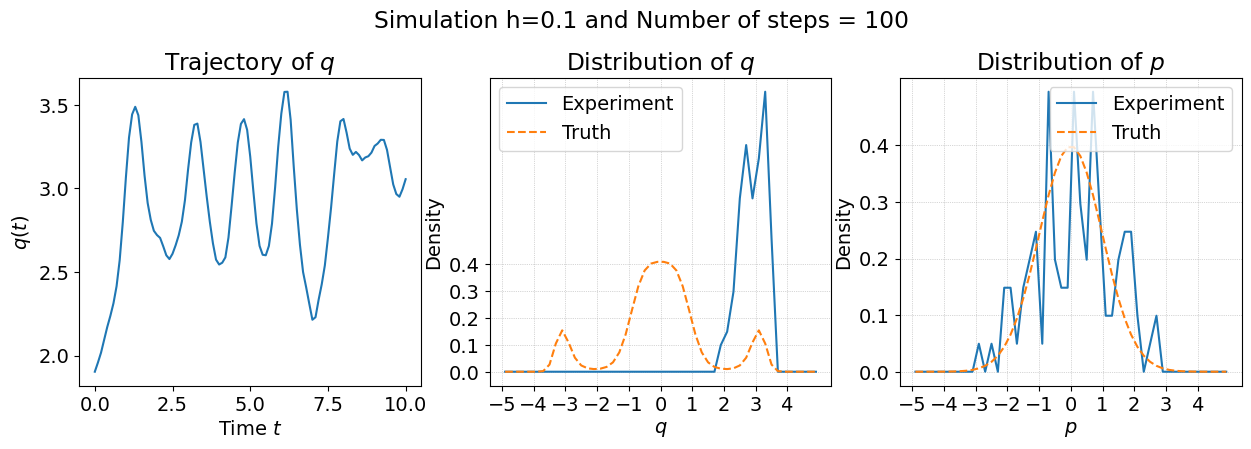

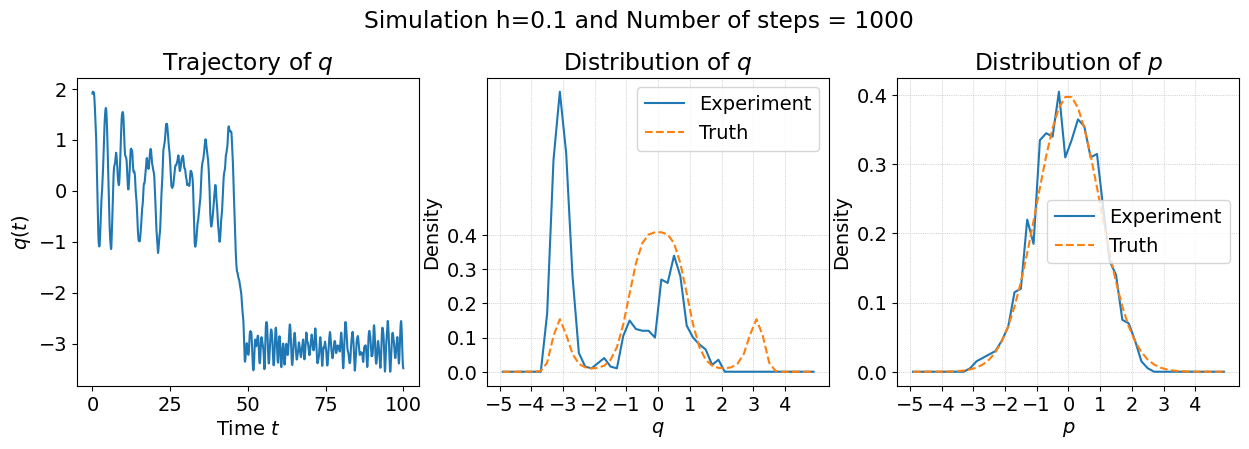

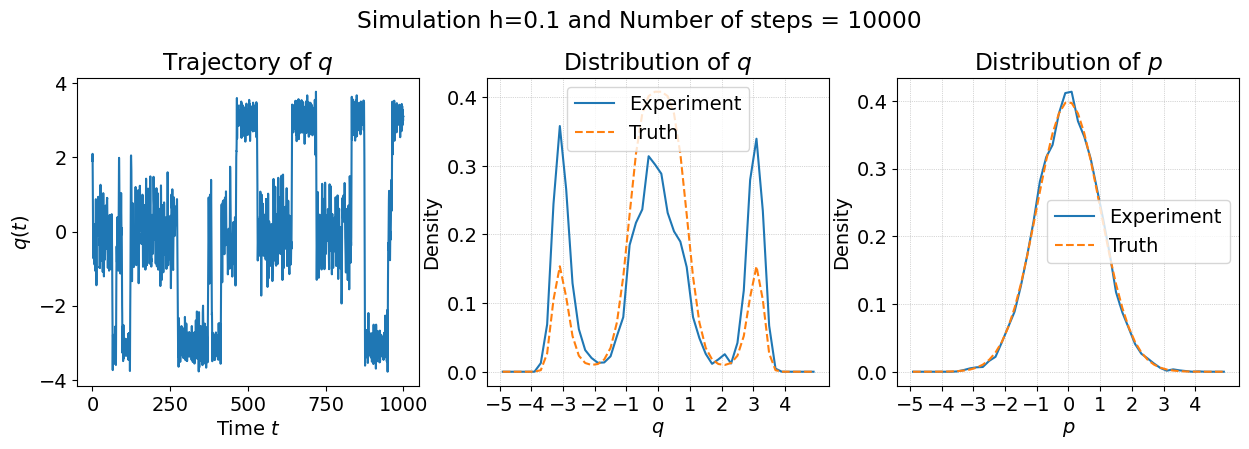

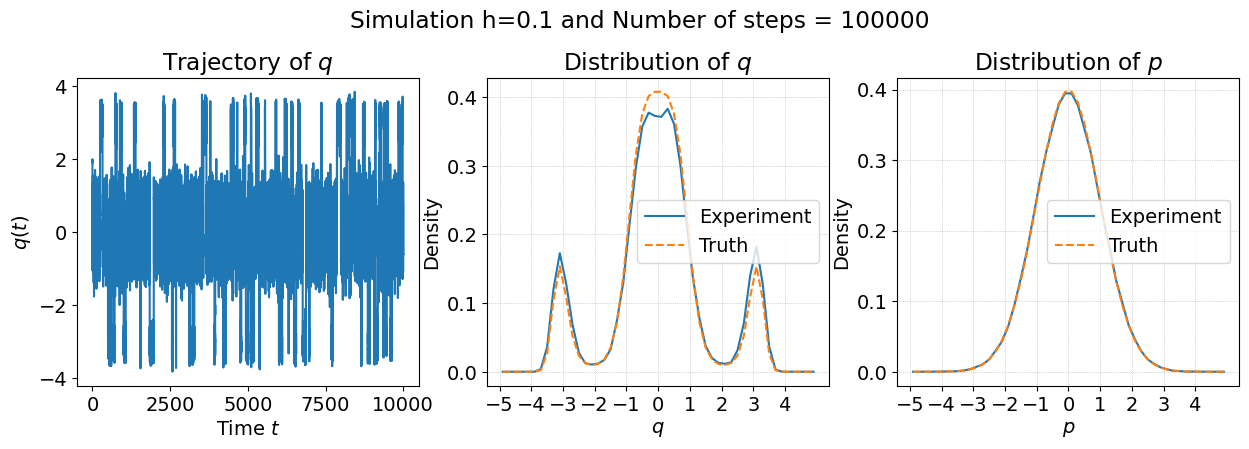

In [42]:
## your work here! 
### Run the simulation 
q0 = np.random.randn(1)
p0 = np.random.randn(1)

h = 0.1 # step size 
Nsteps_list = [ 1e2,1e3, 1e4, 1e5] 
for Nsteps in Nsteps_list: 
    Nsteps =int( Nsteps)
    q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, my_force)
    plot_ex4( q_traj, p_traj, t_traj, h , Nsteps)

Here we see that due to the complex curve shape of the True distruabtion wiht the addition of $U(q) = q^2(.1+\sin^2(q))$ leads to a larger number of steps needed before the simulation is able to fit the true distrubution. Mostly we see that the simulation has diffulty with the small features, namley the small peaks that occur around $q\pm3$, it is only around $N=100000$ we see that these are suitably fitted. Larger $N$ took to long to compute in this case, but one can imagaine the fit improving in sucha  case. Note we also again see the kink for the main peak in the $q$.  

## Analsis  _BAOAB_
In this analysis, we observe that the intricate curve shape of the true distribution, coupled with the addition of the potential term $U(q) = q^2(.1+\sin^2(q))$ , presents challenges for the simulation. Specifically, a larger number of steps is required before the simulation accurately captures the characteristics of the true distribution.

The simulation encounters difficulties in reproducing small features, particularly the minor peaks occurring around $q±3$. These nuances in the distribution are challenging to represent accurately, and it is only when $N$ reaches around $100,000$ that the simulation starts to adequately fit these features. Attempting even larger $N$ values was computationally prohibitive in this case, but it can be envisioned that further increasing $N$ might lead to an improved fit.
Note the persistent presence of a kink in the main peak of the $q$ distribution. This kink is noticeable even at $N=100000$ suggesting that the simulation struggles to fully capture the behavior around the peak.

Additionally, the trajectory plot of qq provides insights into the duration the particle resides within each well formed by the distribution peaks. Notably, due to the larger peak at the center, the particle tends to spend a greater amount of time in this central region. Conversely, the particle exhibits shorter residence times in the smaller peaks, with approximately an even distribution of time among them.

Compare the use of BAOAB to compute observable averages for the following observable functions:
$$\varphi_1(q) = q^2$$
$$\varphi_2(q) = e^{-q^2}$$

In [14]:
## Define the function for phi 1,2.
def phi_one(q):
    U =np.power(q,2)
    return U 

def phi_two(q): 
    U = np.exp( - (q**2)) 
    return U 


In [15]:
q0 = np.random.randn(1) 
p0 = np.random.randn(1) 
h = 0.1 
beta = 1.0
gamma = 1.0
Nsteps = int(1e5)
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, my_force)

## Answer 
Our goal is to compute the expectation of the observable, namely: 
$$ 
\mathbf{E}[\varphi_{i}(q)] = \int_{-\infty}^\infty \varphi_{i}(q) \pi(q) \rm{d}q, 
$$
where the target distribution $pi(q)$ is defined as:
$$
\pi(q) = \frac1{Z_\beta} \exp(-\beta U(q)).
$$
For the specific potential energy function $U(q) = q^2(.1+\sin^2(q))$, we have the following:
$$
Z_\beta=\int_{-\infty}^\infty \exp(-\beta U(q) )\,\rm{d}q =\int_{-\infty}^\infty \exp(- q^2(.1+\sin^2(q)) )\,\rm{d}q,
$$
with $\beta =1$. Using Mathematica this integral can be computed as $ Z_\beta \approx2.459910$, this we can compute $\pi(q)$. 
Therefore the true value for $ \varphi_1 (q)$ is given by 
$$
\mathbf{E}[\varphi_{1}(q)] = \int_{-\infty}^\infty \varphi_{1}(q) \pi(q) \rm{d}q = \int_{-\infty}^\infty \frac{1}{2.45991}q^2 \exp(-q^2(.1+\sin^2(q))) \rm{d}q = 2.35398.
$$
We can compare this to the numerical approximation by computing 
$$
\tilde{ \mathbf{E}}[\varphi_{1}(q)] = \frac{1}{N} \sum_{n=1}^{N} q^2 
$$
which can be computed in the code cell below 

In [65]:
Ephi_1 = np.mean( np.power(q_traj,2) ) 
print(f'Computed numerical: {Ephi_1}. The error : {abs(Ephi_1 - 2.35398)}. ')

Computed numerical: 2.0169532896069935. The error : 0.33702671039300647. 


Similarly, the true value for $ \varphi_2 (q)$ is given by 
$$
\mathbf{E}[\varphi_{2}(q)] = \int_{-\infty}^\infty \varphi_{2}(q) \pi(q) \rm{d}q = \int_{-\infty}^\infty \frac{1}{2.45991}  \exp(-q^2)\exp(-q^2(.1+\sin^2(q))) \rm{d}q = 0.56534.
$$
We can compare this to the numerical approximation by computing 
$$
\tilde{ \mathbf{E}}[\varphi_{2}(q)] = \frac{1}{N} \sum_{n=1}^{N} \exp(-q^2)
$$
and this approximation can be executed in the code cell provided below.

In [67]:
Ephi_2 = np.mean( phi_two(q_traj) ) 
print(f'Computed numerical: {Ephi_2}. The error : {abs(Ephi_2 - 0.56534)}.')

Computed numerical: 0.5855751456975813. The error : 0.020235145697581336.


## Discuss
We see that for $\varphi_1$ the error is quite large, therefore we want to investigate the effects of step size has with the relative error. We expect that the error shall decrease as we increase the number of steps, however the process of doing so increase the compuational cost. 

In [68]:
# setting up 
q0 = np.random.randn(1) 
p0 = np.random.randn(1) 
hs = np.logspace(0, -4, num=10)
beta = 1.0
gamma = 1.0
Nsteps = int(1e5)
error_phi_1 = [] 
error_phi_2 = [] 
for h in hs: 
    q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, my_force)
    error_phi_1.append( abs( np.mean( phi_one(q_traj)) -  2.353982441024815)) 
    error_phi_2.append( abs(np.mean( phi_two(q_traj) ) -  0.5653404265148825))


/tmp/ipykernel_47668/2026598531.py:8: RuntimeWarning: overflow encountered in square
  F = -2*q*(np.sin(q)**2 +0.1) - 2*q**2*np.sin(q)*np.cos(q)
/tmp/ipykernel_47668/2026598531.py:8: RuntimeWarning: invalid value encountered in sin
  F = -2*q*(np.sin(q)**2 +0.1) - 2*q**2*np.sin(q)*np.cos(q)
/tmp/ipykernel_47668/2026598531.py:8: RuntimeWarning: invalid value encountered in cos
  F = -2*q*(np.sin(q)**2 +0.1) - 2*q**2*np.sin(q)*np.cos(q)
/tmp/ipykernel_47668/1066923365.py:3: RuntimeWarning: overflow encountered in power
  U =np.power(q,2)
/tmp/ipykernel_47668/1066923365.py:7: RuntimeWarning: overflow encountered in square
  U = np.exp( - (q**2))


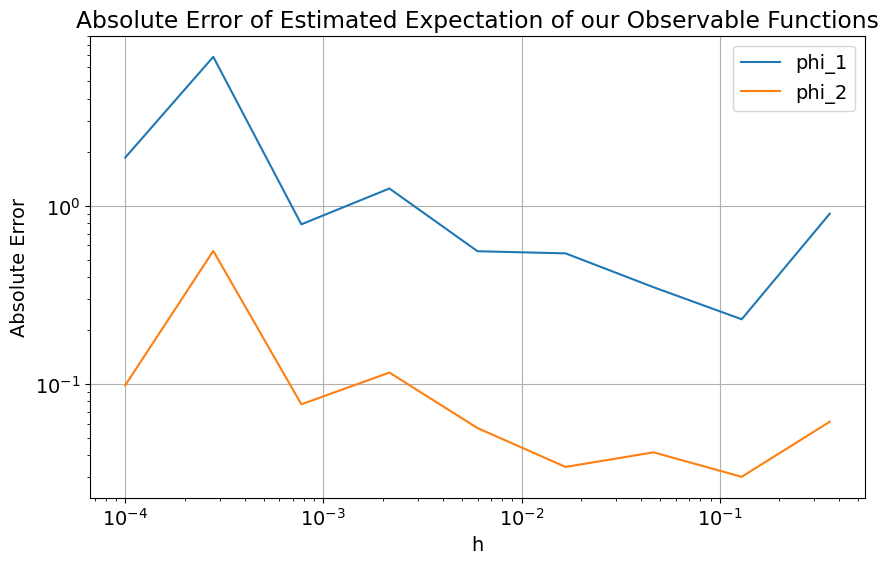

In [70]:
# Plotting the errors
plt.figure(figsize=(10, 6))

plt.loglog(hs, error_phi_1, label='phi_1')
plt.loglog(hs, error_phi_2, label='phi_2')
# Adding labels and title
plt.xlabel('h')
plt.ylabel('Absolute Error')
plt.title('Absolute Error of Estimated Expectation of our Observable Functions')
# Adding grid lines
plt.grid(True)
# Adding legend
plt.legend()


# Display the plot
plt.show()

Here we see that the error associated with $\varphi_2$ is less by an order of magintude than $\varphi_1$. Plotting the functions og $\varphi$ (see below) we see that $\varphi_1$ is quadratic and hence values of $q$ are mapped further away than in the case for $\varphi_2$. 

A notable observation emerges as we compare the errors associated with the observables $\varphi_1$.​ and  $\varphi_2$. the error for $\varphi_2$ is consistently less by an order of magnitude compared to $\varphi_1$​. 
To gain further insight into this behavior, consider the plots of $\varphi$ functions depicted below. Notably, the plot for $\varphi_1$ reveals a quadratic nature, leading to values of $q$ being mapped further away from each other. In contrast, the plot for $\varphi_2$​ exhibits a different behavior, likely contributing to the observed lower error.


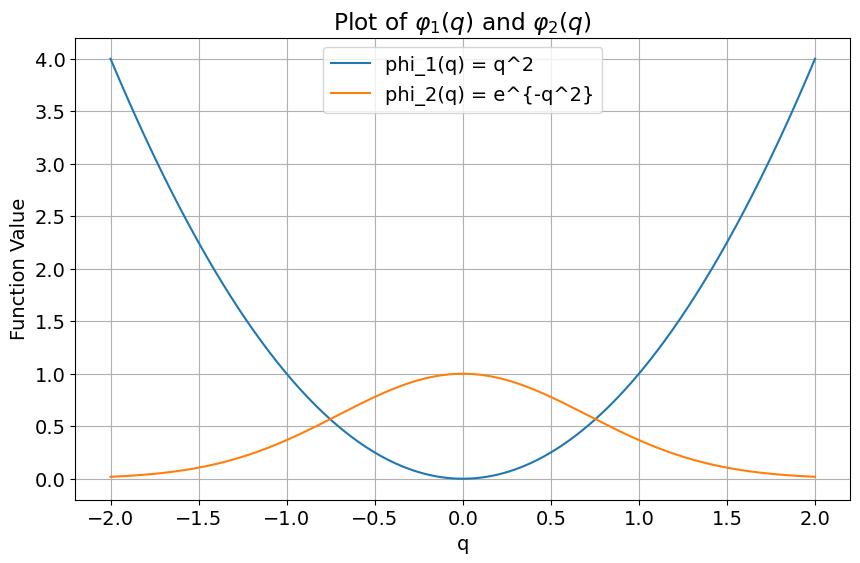

In [76]:
# Generate a range of values for q
q_values = np.linspace(-2, 2, 1000)

# Compute the function values
phi_one_values = phi_one(q_values)
phi_two_values = phi_two(q_values)

# Plot the functions
plt.figure(figsize=(10, 6))

plt.plot(q_values, phi_one_values, label=r'phi_1(q) = q^2 ')
plt.plot(q_values, phi_two_values, label=r'phi_2(q) = e^{-q^2}')

# Add title and labels
plt.title(r'Plot of $\varphi_1(q)$ and $\varphi_2(q)$')
plt.xlabel('q')
plt.ylabel('Function Value')

# Add legend
plt.legend()

# Add grid lines
plt.grid(True)

# The UBU discretization
A recent paper https://arxiv.org/abs/2104.12384v2 highlighted the benefits of an alternative splitting of Langevin dynamics.  In this splitting, we divide the equations differently than in the A,B,O-based methods. 

Instead of those components, the authors suggested

$$
\begin{pmatrix}
dq \\
dp
\end{pmatrix} = \underbrace{\begin{pmatrix}
0 \\
-\nabla U(q)dt
\end{pmatrix}}_{\mathcal{B}} +\underbrace{\begin{pmatrix}
pdt \\
-\gamma p dt + \sqrt{2\gamma}dW_t
\end{pmatrix}}_{\mathcal{U}},
$$

Each of $\mathcal{B}$, $\mathcal{U}$ can be integrated exactly, in the weak sense.  The first term is the same as the B in the A,B,O framework. Isolating the second part we have
$$
\begin{align}
{\rm d}q & = p {\rm d} t\\
{\rm d}p & = -\gamma p dt + \sqrt{2\gamma}dW_t
\end{align}
$$
and we see that the second equation is just the O-equation we had before. It follows that the step in $p$ is defined as above.  Then, as the other part of the $\mathcal{U}$ step, we need to evaluate $q$ as the integral of $p$ (in the setting of stochastic integration).  Given $\gamma > 0$, let $\eta = \exp{\left(-\gamma h\right)}$,let
\begin{equation}\label{eq:Bdef}
\mathcal{B}(q,p,h) = (q,p - h\nabla U(q)),
\end{equation}
and
\begin{equation}\label{eq:Udef}
\begin{split}
\mathcal{U}(q,p,h,\xi^{(1)},\xi^{(2)}) &= \Big(q + \frac{1-\exp{\left(-\gamma h\right)}}{\gamma}p + \sqrt{\frac{2}{\gamma}}\left(\mathcal{Z}^{(1)}\left(h,\xi^{(1)}\right) - \mathcal{Z}^{(2)}\left(h,\xi^{(1)},\xi^{(2)}\right) \right),\\
& v\exp{\left(-\gamma h\right)} + \sqrt{2\gamma}\mathcal{Z}^{(2)}\left(h,\xi^{(1)},\xi^{(2)}\right)\Big),
\end{split}
\end{equation}
where 
\begin{equation}\label{eq:Z12def}
\begin{split}
\mathcal{Z}^{(1)}\left(h,\xi^{(1)}\right) &= \sqrt{h}\xi^{(1)},\\
\mathcal{Z}^{(2)}\left(h,\xi^{(1)},\xi^{(2)}\right) &= \sqrt{\frac{1-\eta^{2}}{2\gamma}}\Bigg(\sqrt{\frac{1-\eta}{1+\eta}\cdot \frac{2}{\gamma h}}\xi^{(1)} + \sqrt{1-\frac{1-\eta}{1+\eta}\cdot\frac{2}{\gamma h}}\xi^{(2)}\Bigg).
\end{split}
\end{equation}
The $\mathcal{B}$ operator indicated here is as given previously, whereas $\mathcal{U}$ as defined above is the exact solution in the weak sense of the remainder of the dynamics when  $\xi^{(1)}, \xi^{(2)} \sim \mathcal{N}\left(0,I_{d}\right)$ are independent random vectors. 

As before, we can have different sequences, for example applying $\mathcal{B}$ then $\mathcal{U}$, each for a stepsize $h$.  Or more complicated combinations of the parts like UBU  are possible which is a half a U step, then a full B step, then half a U step.

Implement UBU discretization for Langevin dynamics and test it by comparing averages computed using it to those obtained from the exact invariant measure.  As potential energy function you should use both (i) the example of the harmonic oscillator and (ii) the potential used in Exercises 4 and 5.   

There are two more systematic computations you can do to compare the methods. 

In [16]:
rng = np.random.default_rng()

### Define a plotting function
def plot_ex6_HO( q_traj, p_traj, t_traj, title_str):
    fig = plt.figure(figsize=[15,4])
    
    plt.subplot(1,3,1)
    plt.plot( t_traj, q_traj )
    plt.title('Trajectory of $q$')
    plt.ylabel('$q(t)$')
    plt.xlabel('Time $t$')
    
    plt.subplot(1,3,2) 
    histogram,bins = np.histogram(q_traj,bins=50,range=[-6,6], density=True)
    midx = (bins[0:-1]+bins[1:])/2

    rho = np.exp(-beta * (midx**2) / 2)
    rho = rho / (np.sum(rho) * (midx[1] - midx[0]))  # Normalize rho by dividing by its approx. integral
  
    plt.plot(midx,histogram,label='Experiment')
    plt.plot(midx,rho,'--',label='Truth')
    plt.title('Distribution of $q$')
    plt.xlabel('$q$')
    plt.ylabel('Density')
    plt.legend()
    
    plt.grid(True, linestyle=':', linewidth=0.5, alpha=1)  # Add darker and more transparent gridlines
    plt.xticks(np.arange(-5, 5, 1))  # Add more x-axis ticks
    plt.yticks(np.arange(0, 0.5, 0.1))  # Add more y-axis ticks

    
    plt.subplot(1, 3, 3) 
    histogram, bins = np.histogram(p_traj, bins=50, range=[-3, 3], density=True)
    midx = (bins[0:-1] + bins[1:]) / 2
    rho = np.exp(-beta * (midx**2) / 2)
    rho = rho / (np.sum(rho) * (midx[1] - midx[0]))  # Normalize rho by dividing by its approx. integral
    plt.plot(midx, histogram, label='Experiment')
    plt.plot(midx, rho, '--', label='Truth')
    plt.title('Distribution of $p$')
    plt.xlabel('$p$')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle=':', linewidth=0.5, alpha=1)  # Add darker and more transparent gridlines
    plt.xticks(np.arange(-3, 4, 1))  # Add more x-axis ticks
    plt.yticks(np.arange(0, 0.4, 0.1))  # Add more y-axis ticks
    
    plt.subplots_adjust(wspace=0.2, hspace=0.5)  # Add more space between subplots
    plt.suptitle(f'Harmonic oscillator, {title_str}: h={h} & N = {Nsteps}', y=1.05)  # Adjust y value for more space
    plt.show()
#### End of HO 



In [17]:
## Define the functions for UBU
def B_step(qp, h, force):
    q,p = np.copy(qp)
    F = force(q)
    p = p + h *F 
    return [q,p] 

def Z_one(h, xi_one):
    return np.sqrt(h)* xi_one

def Z_two(h, xi_one, xi_two, gamma ):
    eta = np.exp(- gamma *h)
    frac1 = np.sqrt( ( 1 - eta*eta)/(2*gamma) ) 
    term1 = ( 1- eta )/( 1+ eta) * (2/ (gamma *h ) )
    frac = (1-eta)/(1+eta)
    frac2 = np.sqrt( term1 ) 
    frac3 = np.sqrt( 1 - term1) 
    return frac1 * ( frac2 * xi_one  + frac3 * xi_two ) 


def U_step(qp, h, force, gamma): 
    q,p = np.copy(qp) 
    F = force(q) 
    
    xi_one = rng.standard_normal(len(q)) 
    xi_two = rng.standard_normal(len(p)) 
    
    eta = np.exp( - gamma * h ) 

    term1 = (1 - eta) / gamma 
    term2 = np.sqrt( 2 / gamma) 

    term3 = np.sqrt( 2* gamma) 

    Z_1 = Z_one(h, xi_one)
    Z_2 = Z_two(h,xi_one, xi_two, gamma )
    

    q = q + term1*p + term2 *( Z_1 - Z_2)
    p = p * eta + term3 *  Z_2
    
    return [q,p]


def ld_UBU(q,p, h, gamma, beta, force): 
    qp =np.copy([q,p])    
    qp = U_step(qp, h/2, force,gamma)
    qp = B_step(qp, h, force) 
    qp = U_step(qp, h/2, force,gamma)

    q,p =qp
    return q,p 

## Harmonic oscillator
Here we set the potential energy function as 
$$
U(q) = q^2 /2.
$$

In [51]:
# U -> Harmonic oscillator. 
q0 = np.random.randn(1) 
p0 = np.random.randn(1) 
h=0.1
gamma = 1.0
beta = 1.0
Nsteps = 10000
q_traj_UBU, p_traj_UBU, t_traj_UBU = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_UBU, force_Gaussian)
q_traj_BAOAB, p_traj_BAOAB, t_traj_BAOAB = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, force_Gaussian)

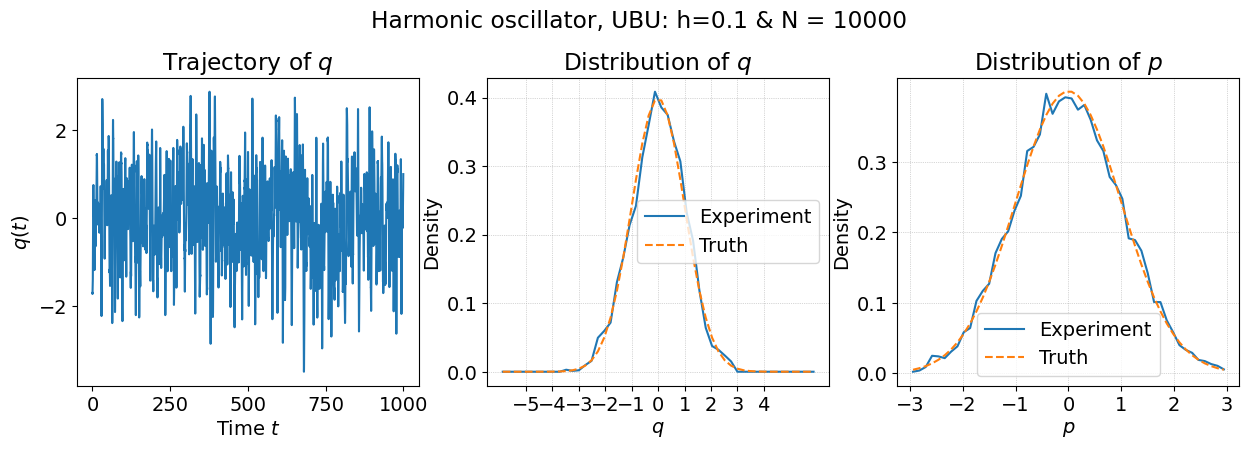

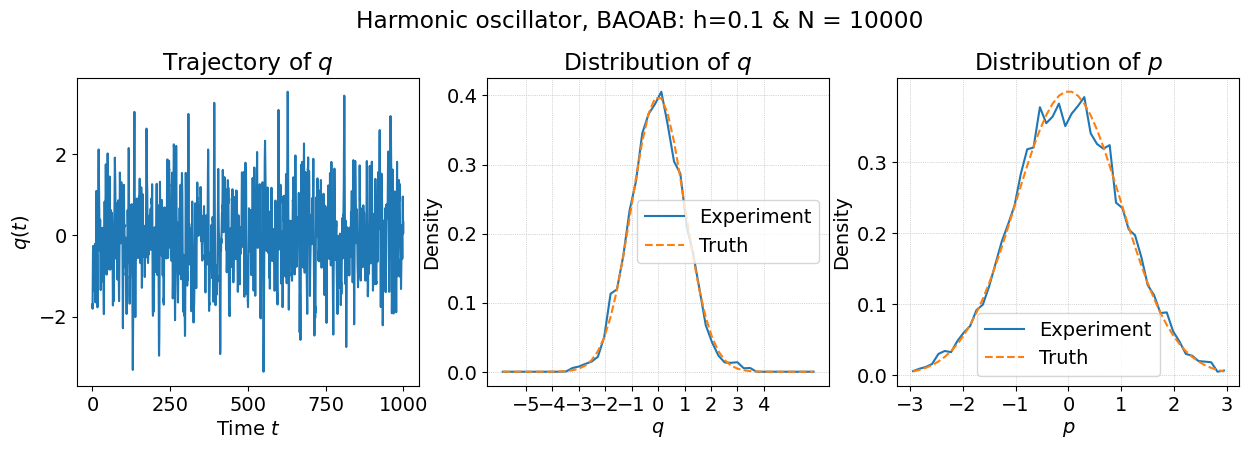

In [59]:
plot_ex6_HO( q_traj_UBU, p_traj_UBU, t_traj_UBU, 'UBU')
plot_ex6_HO( q_traj_BAOAB, p_traj_BAOAB, t_traj_BAOAB, 'BAOAB')

In [96]:
## As in Exercise 5, we shall compute the integral to get he true value:
from scipy.integrate import quad
def integral_Z(q):
    return np.exp( -beta * np.power(q,2) / 2 ) 
# Set the integration limits
lower_limit = -np.inf
upper_limit = np.inf
# Numerically evaluate the integral
z_b_HO, error = quad(integral_Z, lower_limit, upper_limit)
# define the integral for the expectation
def pi(q):
    return 1/ z_b_HO * np.exp( - np.power(q,2) / 2 ) 
    
def E_int_g(q):
    return q* pi(q)
    
def E_int_phi1(q):
    return phi_one(q) * pi(q) 

def E_int_phi2(q):
    return phi_two(q) * pi(q)

E_true_g , e  = quad(E_int_g, lower_limit, upper_limit)
E_true_phi1, e = quad(E_int_phi1, lower_limit, upper_limit)
E_true_phi2, e = quad(E_int_phi2, lower_limit, upper_limit)

E_num_g_UBU    = np.mean(q_traj_UBU) 
E_num_phi1_UBU = np.mean( phi_one( q_traj_UBU))
E_num_phi2_UBU = np.mean( phi_two( q_traj_UBU))

E_num_g_BAOAB    = np.mean(q_traj_BAOAB) 
E_num_phi1_BAOAB = np.mean( phi_one( q_traj_BAOAB))
E_num_phi2_BAOAB = np.mean( phi_two( q_traj_BAOAB))


print(f'E[Gaussian], UBU {abs(E_num_g_UBU - E_true_g):.4f},  BAOAB {abs(E_num_g_BAOAB - E_true_g):.4f}')
print(f'E[[phi_1]  , UBU {abs(E_num_phi1_UBU - E_true_phi1):.4f},  BAOAB {abs(E_num_phi1_BAOAB - E_true_phi1):.4f}')
print(f'E[[phi_2]  , UBU {abs(E_num_phi2_UBU - E_true_phi2):.4f},  BAOAB {abs(E_num_phi2_BAOAB - E_true_phi2):.4f}')

E[Gaussian], UBU 0.3702,  BAOAB 0.4196
E[[phi_1]  , UBU 1.5677,  BAOAB 2.5652
E[[phi_2]  , UBU 0.0378,  BAOAB 0.1237


For 'Gaussian' and $\varphi_2$ we see that BAOAB performs better, but for $ \varphi_1$ UBU has a smaller error. However, both processes are very close to each other in all cases seen here. 

## 
We now set the potential energy function as 
$$
 U(q) = q^2(.1+\sin^2(q))
$$

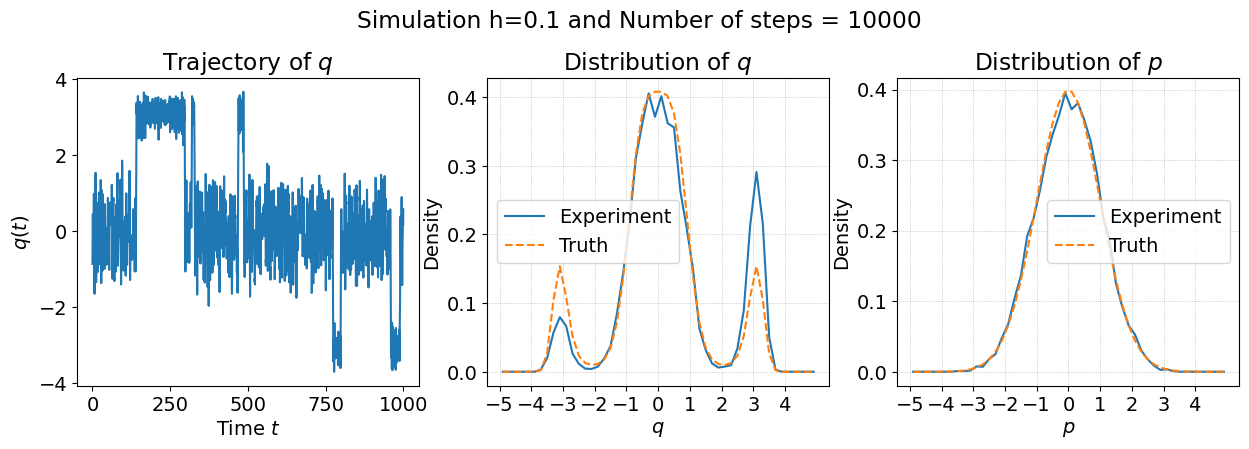

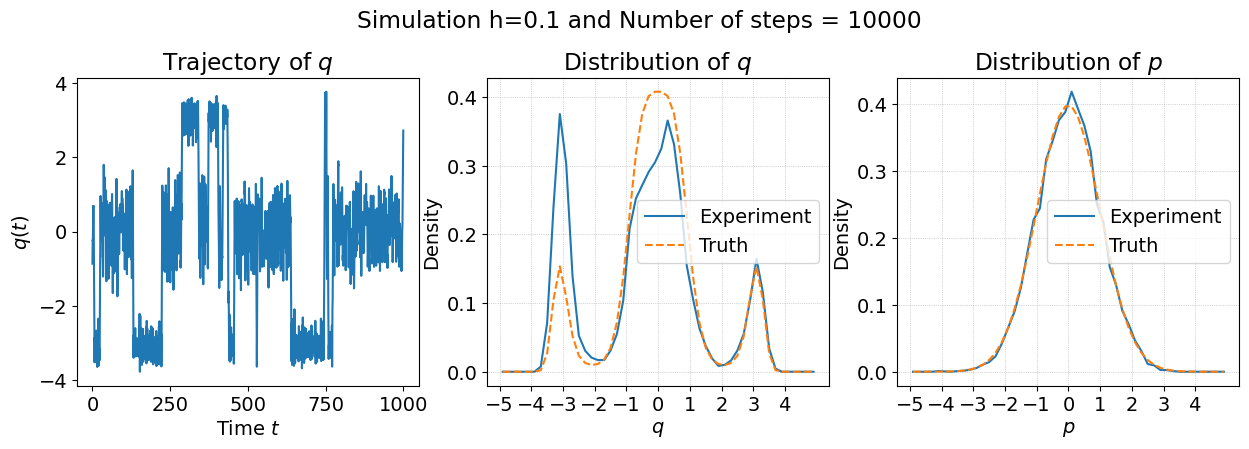

In [93]:
# U -> Harmonic oscillator. 
q0 = np.random.randn(1) 
p0 = np.random.randn(1) 
h=0.1
gamma = 1.0
beta = 1.0
Nsteps = 10000
q_traj_UBU, p_traj_UBU, t_traj_UBU = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_UBU, my_force)
q_traj_BAOAB, p_traj_BAOAB, t_traj_BAOAB = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, my_force)

plot_ex4( q_traj_UBU, p_traj_UBU, t_traj_UBU, h , Nsteps)
plot_ex4( q_traj_BAOAB, p_traj_BAOAB, t_traj_BAOAB, h , Nsteps)

In [95]:
## As in Exercise 5, we shall compute the integral to get he true value:
from scipy.integrate import quad
def integral_Z(q):
    return np.exp( -beta * my_pot(q) ) 
# Set the integration limits
lower_limit = -np.inf
upper_limit = np.inf
# Numerically evaluate the integral
z_b, error = quad(integral_Z, lower_limit, upper_limit)
# define the integral for the expectation
def pi(q):
    return 1/z_b * np.exp(-np.power(q,2) * (0.1 + np.power(np.sin(q),2)))
    
def E_int_g(q):
    return q* pi(q)
    
def E_int_phi1(q):
    return phi_one(q) * pi(q) 

def E_int_phi2(q):
    return phi_two(q) * pi(q)

E_true_g_2 , e  = quad(E_int_g, lower_limit, upper_limit)
E_true_phi1_2, e = quad(E_int_phi1, lower_limit, upper_limit)
E_true_phi2_2, e = quad(E_int_phi2, lower_limit, upper_limit)

E_num_g_UBU    = np.mean(q_traj_UBU) 
E_num_phi1_UBU = np.mean( phi_one( q_traj_UBU))
E_num_phi2_UBU = np.mean( phi_two( q_traj_UBU))

E_num_g_BAOAB    = np.mean(q_traj_BAOAB) 
E_num_phi1_BAOAB = np.mean( phi_one( q_traj_BAOAB))
E_num_phi2_BAOAB = np.mean( phi_two( q_traj_BAOAB))


print(f'E[Gaussian], UBU {abs(E_num_g_UBU - E_true_g_2):.4f},  BAOAB {abs(E_num_g_BAOAB - E_true_g_2):.4f}')
print(f'E[[phi_1]  , UBU {abs(E_num_phi1_UBU - E_true_phi1_2):.4f},  BAOAB {abs(E_num_phi1_BAOAB - E_true_phi1_2):.4f}')
print(f'E[[phi_2]  , UBU {abs(E_num_phi2_UBU - E_true_phi2_2):.4f},  BAOAB {abs(E_num_phi2_BAOAB - E_true_phi2_2):.4f}')

E[Gaussian], UBU 0.3702,  BAOAB 0.4196
E[[phi_1]  , UBU 0.2138,  BAOAB 1.2112
E[[phi_2]  , UBU 0.0258,  BAOAB 0.1117


It becomes evident that the error for $\varphi_1$ and$\varphi_2$ is significantly larger when employing the BAOAB method in comparison to the UBU approach. 
Specifically, when utilizing the BAOAB method, inadequacies in fitting become apparent, especially for the smaller peaks. Instead of a precise fit, the method results in larger spikes at these points, which, in turn, contribute to the increased error observed in the associated error table. This discrepancy may be attributed to the inherent characteristics of the BAOAB algorithm and its performance in capturing nuanced features of the observables.
It is worth noting that increasing the number of simulation steps could potentially mitigate this error. 

Try to evaluate the accuracy of the two methods in approximating the invariant distribution  of the nonlinear problem by carefully computing observable averages for a specific observable and different choices of the stepsize.    You should be able to construct a log-log scale stepsize-error diagram showing how each of UBU and BAOAB perform in terms of the accuracy of observable averages for different stepsizes.   


In [100]:
# setting up 
q0 = np.random.randn(1) 
p0 = np.random.randn(1) 
hs = np.logspace(0, -4, num=10)
beta = 1.0
gamma = 1.0
Nsteps = int(1e5)

error_g_UBU= [] 
error_g_BAOAB= [] 

error_phi1_UBU= [] 
error_phi1_BAOAB= [] 

error_phi2_UBU = [] 
error_phi2_BAOAB= [] 

for h in hs: 
    q_traj_UBU, p_traj_UBU, t_traj_UBU = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_UBU, force_Gaussian)
    q_traj_BAOAB, p_traj_BAOAB, t_traj_BAOAB = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, force_Gaussian)
    # gaussian 
    error_g_UBU.append( abs( E_true_g - np.mean( q_traj_UBU)))
    error_g_BAOAB.append( abs( E_true_g - np.mean(q_traj_BAOAB)))
    # phi 1 
    error_phi1_UBU.append( abs( E_true_phi1 - np.mean(phi_one( q_traj_UBU)) ))
    error_phi1_BAOAB.append( abs( E_true_phi1 - np.mean(phi_one(q_traj_BAOAB))))
    # phi 2
    error_phi2_UBU.append( abs( E_true_phi2 - np.mean(phi_two( q_traj_UBU))))
    error_phi2_BAOAB.append( abs( E_true_phi2 - np.mean(phi_two(q_traj_BAOAB))))
    


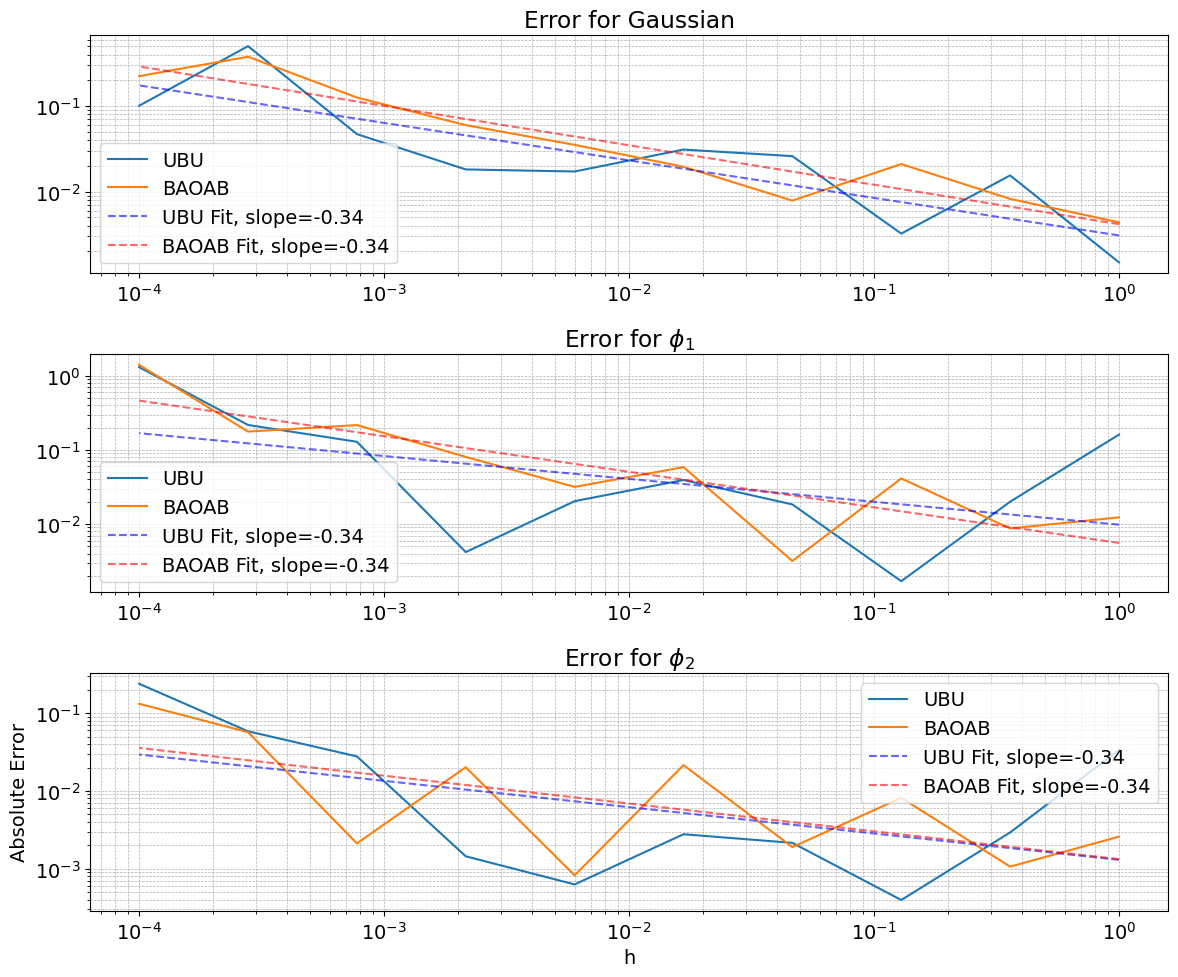

In [110]:
from scipy.optimize import curve_fit

# Define functions for curve fitting (linear regression)
def linear_fit(x, a, b):
    return a * x + b

# Plotting the errors
plt.figure(figsize=(12, 10))

# Gaussian
plt.subplot(3, 1, 1)
plt.loglog(hs, error_g_UBU, label='UBU')
plt.loglog(hs, error_g_BAOAB, label='BAOAB')
plt.title('Error for Gaussian')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Phi 1
plt.subplot(3, 1, 2)
plt.loglog(hs, error_phi1_UBU, label='UBU')
plt.loglog(hs, error_phi1_BAOAB, label='BAOAB')
plt.title('Error for $\phi_1$')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Phi 2
plt.subplot(3, 1, 3)
plt.loglog(hs, error_phi2_UBU, label='UBU')
plt.loglog(hs, error_phi2_BAOAB, label='BAOAB')
plt.title('Error for $\phi_2$')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adding labels and a fine grid
plt.xlabel('h')
plt.ylabel('Absolute Error')

# Fit lines
fit_range = hs[1:]  # excluding the first point for better fitting
popt_UBU, _ = curve_fit(linear_fit, np.log(hs), np.log(error_g_UBU))
popt_BAOAB, _ = curve_fit(linear_fit, np.log(hs), np.log(error_g_BAOAB))
plt.subplot(3, 1, 1)
plt.loglog(hs, np.exp(linear_fit(np.log(hs), *popt_UBU)), 'b--', label=f'UBU Fit, slope={popt[0]:.2f}', alpha=0.6)
plt.loglog(hs, np.exp(linear_fit(np.log(hs), *popt_BAOAB)),'red', linestyle='--', label=f'BAOAB Fit, slope={popt[0]:.2f}',alpha=0.6)
plt.legend()

popt_UBU, _ = curve_fit(linear_fit, np.log(hs), np.log(error_phi1_UBU))
popt_BAOAB, _ = curve_fit(linear_fit, np.log(hs), np.log(error_phi1_BAOAB))
plt.subplot(3, 1, 2)
plt.loglog(hs, np.exp(linear_fit(np.log(hs), *popt_UBU)),'b--', label=f'UBU Fit, slope={popt[0]:.2f}',alpha=0.6)
plt.loglog(hs, np.exp(linear_fit(np.log(hs), *popt_BAOAB)),'red', linestyle='--', label=f'BAOAB Fit, slope={popt[0]:.2f}',alpha=0.6)
plt.legend()

popt_UBU, _ = curve_fit(linear_fit, np.log(hs), np.log(error_phi2_UBU))
popt_BAOAB, _ = curve_fit(linear_fit, np.log(hs), np.log(error_phi2_BAOAB))
plt.subplot(3, 1, 3)
plt.loglog(hs, np.exp(linear_fit(np.log(hs), *popt_UBU)),'b--', label=f'UBU Fit, slope={popt[0]:.2f}',alpha=0.6)
plt.loglog(hs, np.exp(linear_fit(np.log(hs), *popt_BAOAB)),'red', linestyle='--', label=f'BAOAB Fit, slope={popt[0]:.2f}',alpha=0.6)

plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

It becomes evident that both the UBU and BAOAB methods exhibit a remarkable similarity. This observation is substantiated by the nearly identical best fit lines obtained for the two methods.

Find any differences between the methods in their convergence to equilibrium.  You can study this by graphing the autocorrelation function of the observable.   There are some notes on calculating rates of convergence (autocorrelation times and effective sample sizes) in these works: 

Fang, Youhan, Yudong Cao, and Robert D. Skeel. 2017. “Quasi-Reliable Estimates of Effective Sample Size.” arXiv:1705.03831 [Stat], May.

Geyer, Charles J. 1992. “Practical Markov Chain Monte Carlo.” Statistical Science 7 (4): 473–83.

And some slides here:
https://icerm.brown.edu/materials/Slides/tw-16-5/Quasi-Reliable_Estimates_of_Effective_Sample_Size_]_Robert_Skeel,_Purdue_University.pdf

and a software package here:
https://github.com/dfm/acor


Insights from the provided resource 
(https://rstudio-pubs-static.s3.amazonaws.com/258436_5c7f6f9a84bd47aeaa33ee763e57a531.html),
we can adapt and implement a fast autocorrelation function in Python. This function efficiently computes the autocorrelation of a given time series, leveraging the Fast Fourier Transform (FFT) for enhanced computational speed.


The Integrated Autocorrelation Time (IAT), often denoted as τ (tau), is a measure used in Markov Chain Monte Carlo (MCMC) simulations to quantify the degree of correlation between successive samples generated by the Markov chain. The IAT provides information about how quickly the Markov chain converges to its stationary distribution.

In the context of MCMC, the IAT is particularly relevant for understanding the efficiency of the sampling process. The key idea is that if the samples in the Markov chain are highly correlated, it takes longer for the chain to explore the full state space and converge to the target distribution. In contrast, if the samples are less correlated, the chain converges more quickly.

In [18]:
def auto_corr_fast(M, lag = 200): # FFT to compute autocorrelation efficiently
    M = M - np.mean(M)
    N = len(M)
    fvi = np.fft.fft(M, n=2*N)
    G = np.real( np.fft.ifft( fvi * np.conjugate(fvi) )[:N] )
    G /= N - np.arange(N); G /= G[0]
    G = G[:lag]
    return G

def tau(M, lag = 200):
    autocorr = auto_corr_fast(M, lag)
    return 1 + 2*np.sum(autocorr), autocorr

### Case 1:
Consider the potential energry given by 
$$
U(q) = q^2 /2.
$$


In [38]:
# setting up 
q0 = np.random.randn(1) 
p0 = np.random.randn(1) 
h = 0.1
beta = 1.0
gamma = 1.0
Nsteps = int(1e5)

q_traj_UBU, p_traj_UBU, t_traj_UBU = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_UBU, force_Gaussian)
q_traj_BAOAB, p_traj_BAOAB, t_traj_BAOAB = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, force_Gaussian)

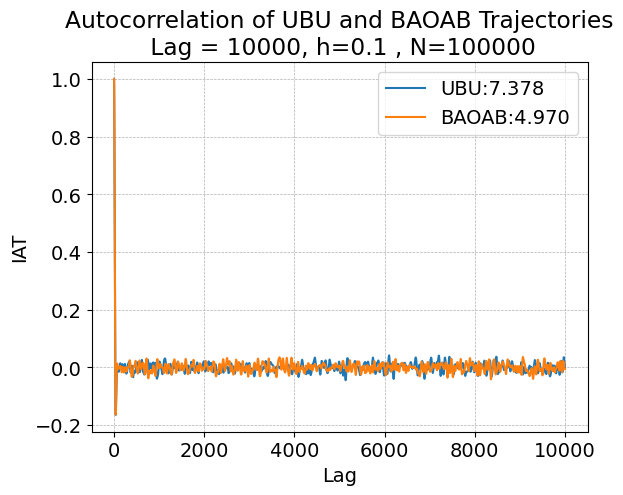

In [39]:
lag =10000
tau_UBU, acor_UBU = tau(q_traj_UBU.reshape(-1), lag=lag)
tau_BAOAB, acor_BAOAB = tau(q_traj_BAOAB.reshape(-1), lag=lag)

plt.plot(np.arange(len(acor_UBU)), acor_UBU, label=f'UBU:{tau_UBU:.3f}')
plt.plot(np.arange(len(acor_BAOAB)), acor_BAOAB, label=f'BAOAB:{tau_BAOAB:.3f}')

plt.legend()
plt.xlabel('Lag')
plt.ylabel('IAT')
plt.title(f'Autocorrelation of UBU and BAOAB Trajectories\n Lag = {lag}, h={h} , N={Nsteps}')
plt.grid(True, linestyle='--', linewidth=0.5)

plt.show()

We observe a similarity in the IAT between the UBU and BAOAB methods. This observation is evident as the corresponding curves for the two methods exhibit a substantial degree of overlap, emphasizing their close resemblance to each other. The comparable nature of the IAT curves suggests that both UBU and BAOAB demonstrate similar rates of convergence

### Case 2:
We now set the potential energy function as 
$$
 U(q) = q^2(.1+\sin^2(q))
$$


In [31]:
# setting up 
q0 = np.random.randn(1) 
p0 = np.random.randn(1) 
h = 0.1
beta = 1.0
gamma = 1.0
Nsteps = int(1e5)

q_traj_UBU, p_traj_UBU, t_traj_UBU = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_UBU, my_force)
q_traj_BAOAB, p_traj_BAOAB, t_traj_BAOAB = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_BAOAB, my_force)

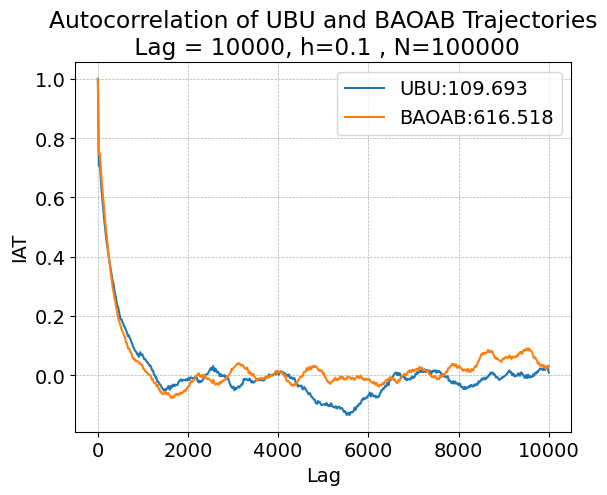

In [33]:
lag =10000
tau_UBU, acor_UBU = tau(q_traj_UBU.reshape(-1), lag=lag)
tau_BAOAB, acor_BAOAB = tau(q_traj_BAOAB.reshape(-1), lag=lag)

plt.plot(np.arange(len(acor_UBU)), acor_UBU, label=f'UBU:{tau_UBU:.3f}')
plt.plot(np.arange(len(acor_BAOAB)), acor_BAOAB, label=f'BAOAB:{tau_BAOAB:.3f}')

plt.legend()
plt.xlabel('Lag')
plt.ylabel('IAT')
plt.title(f'Autocorrelation of UBU and BAOAB Trajectories\n Lag = {lag}, h={h} , N={Nsteps}')
plt.grid(True, linestyle='--', linewidth=0.5)

plt.show()